In [1]:
import numpy as np
import duckdb
import pandas as pd
import seaborn as sns
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
data = pd.read_csv("BDC_2024_Womens_Data.csv")

In [3]:
data.columns

Index(['Date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2'],
      dtype='object')

In [4]:
# Divide based on team one canda and one usa
# Corsi For (CF) = Shot attempts for at even strength: Shots + Blocks + Misses[2]
# Corsi Against (CA) = Shot attempts against at even strength: Shots + Blocks + Misses
shot_attempts = duckdb.sql("""
                            SELECT Player, 
                            COUNT(Event) AS "Total Attempted",
                            COUNT (CASE WHEN Event = 'Goal' THEN 1 END) AS "Success"
                            FROM data
                            WHERE Event = 'Goal' OR Event = 'Shot'
                            GROUP BY Player
                           """).df()

shot_attempts["Success Rate"] = round(
    shot_attempts["Success"]/shot_attempts["Total Attempted"], 4)

In [5]:
shot_attempts

,Player,Total Attempted,Success,Success Rate
0,Hilary Knight,16,2,0.1250
1,Brianne Jenner,21,1,0.0476
2,Taylor Heise,16,1,0.0625
3,Alex Carpenter,15,3,0.2000
4,Megan Keller,14,1,0.0714
5,Grace Zumwinkle,3,0,0.0000
6,Marie-Philip Poulin,16,0,0.0000
7,Renata Fast,20,0,0.0000
8,Jocelyne Larocque,16,0,0.0000
9,Hannah Bilka,12,1,0.0833


In [6]:
# Another possible direction? -- What differentiates a goal vs a shot?
# Who are the good goalies of the game?

# On net but unsuccessful = goalie saved
# One-timer: a shot that occurs when a player meets a teammate's pass with an 
# immediate slapshot, without any attempt to control the puck on their stick.

# Traffic: a condensed area on the ice that has a high concentration of players 

unsuccessful_shot = duckdb.sql("""
                                SELECT Player, Event,
                               "Detail 1", "Detail 2", "Detail 3", "Detail 4"
                               FROM data
                               WHERE Event = 'Shot'
                               """).df()


unsuccessful_shot

successful_shot = duckdb.sql("""
                                SELECT Player, Event,
                               "Detail 1", "Detail 2", "Detail 3", "Detail 4"
                               FROM data
                               WHERE Event = 'Goal'
                               """).df()


# Which types of shot yield more success?
# Hypothesis Test: 
# Null Test: All types of shots have the same chances of yielding a goal.
# Alternative Test: There is a type of shot that yields goals more common

# Part 2: The Relationship Between Distance and Scoring a Goal
# By: Ying Lin Zhao

In this portion, we look to analyze the strength of the relationship between
euclidian distance and angle and scoring a goal.  

Although angle of the shot attempts were not provided, the angle at which the 
shot attempted and whether or not the shot was a goal can be cruicial. The angle
at which the shot was attempted may lead to some difference in the result. 

For the purpose of standardizing the hockey field and given the coordinate
field, we set the center of the field to be (189, 42.5). 

In [7]:
shot_distance = duckdb.sql("""
                            SELECT Player, Event,
                           "X Coordinate" AS X_Coordinate,
                           "Y Coordinate" AS Y_Coordinate
                           FROM data
                           WHERE (Event = 'Goal' OR Event = 'Shot')
                            """).df()

In [8]:
# The function will use arctangent to calculate the angle using two ordered pairs.
# Precondition, x1 must be the same type as y1. x2 must be the same type as y2.
# Parameters: 
    # x - a vector list or single value of the x-coordinate of point 1
    # y - a vector list or single value of the y-coordinate of point 1
    # x2 - a vector list or single value of the x-coordinate of point 2
    # y2 - a vector list or single value of the y-coordinate of point 2
    # vector - an array or single value where the calculated values will be saved.
def angle (x, y, x2, y2, vector):
    assert(type(x) == type(y))
    assert(type(x2) == type(y2))
    #if (type(x2) == int and type(y2) == int):
    y_dist = y - y2
    x_dist = x - x2
    for i in range(len(x_dist)):
        if (y_dist[i] == 0):
            vector[i] = 0
        elif (x_dist[i] == 0):
            vector[i] = math.pi / 2
        else:
            vector[i] = abs(math.atan(y_dist[i]/x_dist[i]))
    # else:
    #     y_dist = y - y2
    #     x_dist = x - x2
    #     for i in range(len(x_dist)):
    #         if 



# This function uses the formula of Euclidean Distance between 2 points to calculate
# distance given points.
# Precondition, x1 must be the same type as y1. x2 must be the same type as y2.
    # x1 - a vector list or single value of the x-coordinate of point 1
    # y2 - a vector list or single value of the y-coordinate of point 1
    # x2 - a vector list or single value of the x-coordinate of point 2
    # y2 - a vector list or single value of the y-coordinate of point 2
    # vector - an array or single value where the calculated values will be saved.
def euclidean_dist (x1, y1, x2, y2, vector):
    assert(type(x1) == type(y1))
    assert(type(x2) == type(y2))
    x_diff = x1 - x2
    y_diff = y1 - y2
    for i in range (len(x1)):
        vector[i] = np.sqrt((x_diff[i])**2 + (y_diff[i])**2)

In [9]:
angle_vector = np.zeros(len(shot_distance))

angle(shot_distance["X_Coordinate"], shot_distance["Y_Coordinate"],
                               189.0, 42.5, angle_vector)

#print(angle_vector)
#print (shot_distance["Y Coordinate"][2])
#Currently negative angles are allowed, do we want that to be true? or all positives?
shot_distance["Shot Angle"] = angle_vector

dist_vector = np.zeros(len(shot_distance))
euclidean_dist(shot_distance["X_Coordinate"], shot_distance["Y_Coordinate"],
                               189.0, 42.5, dist_vector)

shot_distance["Shot Distance"] = dist_vector


In [10]:
shot_distance

,Player,Event,X_Coordinate,Y_Coordinate,Shot Angle,Shot Distance
0,Hilary Knight,Goal,185,37,0.942000,6.800735
1,Brianne Jenner,Goal,179,51,0.704494,13.124405
2,Taylor Heise,Goal,175,53,0.643501,17.500000
3,Alex Carpenter,Goal,175,53,0.643501,17.500000
4,Megan Keller,Shot,129,5,0.558599,70.754858
...,...,...,...,...,...,...
418,Taylor Heise,Shot,154,41,0.042831,35.032128
419,Taylor Heise,Shot,170,55,0.581905,22.743131
420,Ella Shelton,Shot,140,36,0.131883,49.429242
421,Sarah Nurse,Shot,163,45,0.095859,26.119916


In [11]:
# Adding a binary column to the dataframe, where if event was a goal,
# then would be encoded as 1. If the event was only a shot, the entry
# would be 0. 
shot_distance["Goal"] = np.where(shot_distance["Event"] == "Goal", 1, 0)
shot_distance

X = shot_distance[["Shot Distance", "Shot Angle"]]
X = sm.add_constant(X)
y = shot_distance["Goal"]

X.corr(method = "pearson")

,const,Shot Distance,Shot Angle
const,NaN,NaN,NaN
Shot Distance,NaN,1.000000,-0.237069
Shot Angle,NaN,-0.237069,1.000000


Prior to creating a logistic regression, it is necessary to ensure there is no collinearly in the independent variables. As shown by the correlation matrix, there is no strong correlation between the shot distance and shot angle and we can proceed.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 2950)
logit_dist = sm.Logit(endog= y_train, exog= X_train).fit()

# Obtaining the estimates
dist_coef = np.round(logit_dist.params[1], 4)
angle_coef = np.round(logit_dist.params[2], 4)
logit_dist.summary()

# train_predictions = logit_dist.predict(X_train)
# print (train_predictions)
# print (train_predictions.shape)
# print (type(train_predictions))

# y_pred = np.zeros(len(train_predictions))

# for i in range (0,296):
#     if train_predictions.iloc[i] >= 0.5:
#         y_pred[i] = 1
#     else:
#         y_pred[i] = 0

# print (y_pred)

# print ("Recall is ", recall_score(y_train, y_pred))

Optimization terminated successfully.
         Current function value: 0.162983
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Goal   No. Observations:                  296
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.1444
Time:                        10:51:15   Log-Likelihood:                -48.243
converged:                       True   LL-Null:                       -56.382
Covariance Type:            nonrobust   LLR p-value:                 0.0002920
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.9255      0.669     -1.384      0.166      -2.236       0.385
Shot Distance    -0.0842      0.026     -3.259      0.001      -0.135      -0.034
Shot Angle       -0.2537      0.672     -0.378      0.706      -1.571       1.063
=================================================================================
"""

### Shot Distance with Goals Made
As showns by the results above, the coefficient for shot distance is approximately -0.0852 with a p-value of of 0.001. 
As the euclidean distance to the goal increases by 1 unit in the field, the odds of a goal being made is multiplied by 0.9183 or exp(-0.0852). 
This provides strong statistical evidence that there is a relationship between shot distance and whether the goal is successfully made. However, this relationship between distance and whether or not the goal is made is an extremely weak, negative one. This result demonstrates that rather than distance, other factors like speed of the puck and type of shot may matter more. As players looking to make a shot approaches the goal, it is likely that players of the opposing team will focus on the player with the puck to better defend against the shot. 

### Shot Angle with Goals Made
As for the angle of the shot, the coefficient is approximately -0.5757 with a p-value of 0.15. 
As the angle between the goal and the shot increases by 1 degree in the field, the odds of a goal being made is multiplied by 0.5623 or exp(-0.5757). 
This suggest that we fail to reject the null hypothesis that the angle does not have a relationship with whether a goal is made more not. Although, the results are not statisically significant, the coefficient being negative make sense given that the center of the goal is viewed as the 0 degrees mark. With that, as players make shot attempts near the edges rather than the middle, the challenge of angle may further hinder the chance of making a goal.

# Bigger Picture Analysis Abandon cause no significant results

In a real life game, it is often difficult to isolate one single factor that determines or signifies if a shot is successful or not. As a result, in many situations, whether or not the goal is made is a combination of various factors (location, angle, personal skill, goalie, one-timer, whether or not traffic is present, etc.). Therefore, after isolating the individual factors, that is associated with shots and goals, we wanted to get the bigger picture of a game and to analyze the important factors and the statistical weight they hold.

In [13]:
analysis_df = duckdb.sql("""
                        SELECT Player, Event,
                        "X Coordinate" AS X_Coordinate, 
                        "Y Coordinate" AS Y_Coordinate, 
                         "Detail 1" AS "Shot Type",
                         "Detail 3" AS "Traffic",
                         "Detail 4" AS "One-Timer"
                         FROM data
                         WHERE (Event = 'Goal' OR Event = 'Shot')
                        """).df()

angle_a = np.zeros(len(analysis_df))
dist_a = np.zeros(len(analysis_df))

angle(analysis_df["X_Coordinate"], analysis_df["Y_Coordinate"],
                               189.0, 42.5, angle_a)

analysis_df["Angle (Radians)"] = angle_a

euclidean_dist(shot_distance["X_Coordinate"], shot_distance["Y_Coordinate"],
                               189.0, 42.5, dist_a)

analysis_df["Euclid. Dist"] = dist_a

success_rate = shot_attempts[["Player", "Success Rate"]]

analysis_df = duckdb.sql("""
                        SELECT *
                        FROM analysis_df 
                        LEFT JOIN success_rate
                        ON analysis_df.Player = success_rate.Player
                        """).df()

analysis_df = analysis_df.drop(columns=["Player_2"])

# Conversion of the booleans into integer to use as binary variable
analysis_df["Traffic"].replace({"f": 0, "t": 1}, inplace=True)
analysis_df["One-Timer"].replace({"f": 0, "t": 1}, inplace=True)
# Rename Column and conversion of event to integer
analysis_df["Goal"] = np.where(analysis_df["Event"] == "Goal", 1, 0)

# Creation of dummy columns for categorical column, shot type
# Bat is dropped and is currently the reference level
shot_dummies = pd.get_dummies(analysis_df["Shot Type"], drop_first = True)
analysis_df = pd.concat([analysis_df, shot_dummies], axis = 1)

# Conversion of the booleans into integer to use as binary variable
analysis_df["Deflection"].replace({False: 0, True: 1}, inplace=True)
analysis_df["Fan"].replace({False: 0, True: 1}, inplace=True)
analysis_df["Poke"].replace({False: 0, True: 1}, inplace=True)
analysis_df["Slapshot"].replace({False: 0, True: 1}, inplace=True)
analysis_df["Snapshot"].replace({False: 0, True: 1}, inplace=True)
analysis_df["Wrap Around"].replace({False: 0, True: 1}, inplace=True)
analysis_df["Wristshot"].replace({False: 0, True: 1}, inplace=True)


In [14]:
analysis_df

,Player,Event,X_Coordinate,Y_Coordinate,Shot Type,Traffic,One-Timer,Angle (Radians),Euclid. Dist,Success Rate,Goal,Deflection,Fan,Poke,Slapshot,Snapshot,Wrap Around,Wristshot
0,Hilary Knight,Goal,185,37,Wristshot,0,0,0.942000,6.800735,0.1250,1,0,0,0,0,0,0,1
1,Brianne Jenner,Goal,179,51,Wristshot,0,0,0.704494,13.124405,0.0476,1,0,0,0,0,0,0,1
2,Taylor Heise,Goal,175,53,Snapshot,0,1,0.643501,17.500000,0.0625,1,0,0,0,0,1,0,0
3,Alex Carpenter,Goal,175,53,Wristshot,0,0,0.643501,17.500000,0.2000,1,0,0,0,0,0,0,1
4,Megan Keller,Shot,129,5,Snapshot,0,0,0.558599,70.754858,0.0714,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Emma Maltais,Shot,184,52,Snapshot,0,0,1.086318,10.735455,0.0000,0,0,0,0,0,1,0,0
419,Emma Maltais,Shot,186,25,Wristshot,0,0,1.401018,17.755281,0.0000,0,0,0,0,0,0,0,1
420,Emma Maltais,Shot,188,47,Snapshot,0,1,1.352127,4.609772,0.0000,0,0,0,0,0,1,0,0
421,Emma Maltais,Shot,181,42,Deflection,0,1,0.062419,8.015610,0.0000,0,1,0,0,0,0,0,0


In [15]:
X_all = duckdb.sql("""
                   SELECT Traffic, "One-Timer", "Angle (Radians)", 
                   "Euclid. Dist", "Success Rate", Deflection, 
                   Fan, Poke, Slapshot, "Wrap Around", Wristshot
                   FROM analysis_df
                   """).df()

y_all = duckdb.sql("""SELECT Goal
                   FROM analysis_df
                   """).df()

print (X_all)




     Traffic  One-Timer  Angle (Radians)  Euclid. Dist  Success Rate  \
0          0          0         0.942000      6.800735        0.1250   
1          0          0         0.704494     13.124405        0.0476   
2          0          1         0.643501     17.500000        0.0625   
3          0          0         0.643501     17.500000        0.2000   
4          0          0         0.558599     70.754858        0.0714   
..       ...        ...              ...           ...           ...   
418        0          0         1.086318     10.735455        0.0000   
419        0          0         1.401018     17.755281        0.0000   
420        0          1         1.352127      4.609772        0.0000   
421        0          1         0.062419      8.015610        0.0000   
422        0          0         0.463648      3.354102        0.0000   

     Deflection  Fan  Poke  Slapshot  Wrap Around  Wristshot  
0             0    0     0         0            0          1  
1        

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                     test_size = 0.3, 
                                                     random_state = 2950)
logit_goal2 = sm.Logit(endog = y_train, exog = X_train).fit()

logit_goal2.summary()

         Current function value: 0.146426
         Iterations: 35


/Users/yzhao/anaconda3/envs/info2950/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Goal   No. Observations:                  296
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                           10
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.3037
Time:                        12:24:46   Log-Likelihood:                -43.342
converged:                      False   LL-Null:                       -62.244
Covariance Type:            nonrobust   LLR p-value:                 4.106e-05
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Traffic            -0.9079      0.968     -0.938      0.348      -2.805       0.990
One-Timer          -0.6649      0.744     -0.893      0.372      -2.123       0.794
Angle (Radians)    -2.6640      0.737     -3.613      0.000      -4.109      -1.219
Euclid. Dist       -0.0736      0.027     -2.679      0.007      -0.127      -0.020
Success Rate        9.9354      2.763      3.596      0.000       4.521      15.350
Deflection         -1.2503      0.930     -1.345      0.179      -3.073       0.572
Fan               -18.4788   1.24e+04     -0.001      0.999   -2.42e+04    2.42e+04
Poke              -26.2025   3.27e+05  -8.02e-05      1.000   -6.41e+05    6.41e+05
Slapshot          -16.3699   6896.429     -0.002      0.998   -1.35e+04    1.35e+04
Wrap Around       -11.4658   1174.570     -0.010      0.992   -2313.580    2290.648
Wristshot          -0.0043      0.654     -0.007      0.995      -1.287       1.278
===================================================================================
"""

## Pass Analysis
What indicates a good pass? 
What angle maximizes chances of indirect pass?
If distance reaches a certain value, does the probability of a pass increase?

In [17]:
df_pass = duckdb.sql("""
                    SELECT Player, Event,
                    "X Coordinate" AS "X",
                    "Y Coordinate" AS "Y",
                     "Player 2",
                    "X Coordinate 2" AS "X2",
                    "Y Coordinate 2" AS "Y2",
                     "Detail 1" AS "Type"
                    FROM data
                    WHERE (Event = 'Play' OR Event = 'Incomplete Play')
                    """).df()

In the space below, we will use the angle and euclidean distance functions to calculate the angle and distance between the two players involved in a play. Then, we proceeded to code the type of play and whether or not it was a successful play as binary values. 

In [18]:
pass_angle = np.zeros(len(df_pass))
pass_distance = np.zeros(len(df_pass))

angle(df_pass["X"],df_pass["Y"],df_pass["X2"],df_pass["Y2"],pass_angle)
euclidean_dist(df_pass["X"],df_pass["Y"],df_pass["X2"],df_pass["Y2"],pass_distance)

df_pass["Angle"] = pass_angle
df_pass["Distance"] = pass_distance

df_pass["Success"] = np.where(df_pass["Event"] == "Play", 1, 0)
df_pass["Direct"] = np.where(df_pass["Type"] == "Direct", 1, 0)


In [19]:
df_pass

,Player,Event,X,Y,Player 2,X2,Y2,Type,Angle,Distance,Success,Direct
0,Jocelyne Larocque,Play,3,59,Renata Fast,4.0,35.0,Indirect,1.529154,24.020824,1,0
1,Renata Fast,Play,6,21,Emma Maltais,48.0,2.0,Direct,0.424832,46.097722,1,1
2,Renata Fast,Play,9,9,Blayre Turnbull,48.0,82.0,Indirect,1.080128,82.764727,1,0
3,Marie-Philip Poulin,Play,78,32,Blayre Turnbull,99.0,30.0,Direct,0.094952,21.095023,1,1
4,Megan Keller,Play,2,36,Hilary Knight,26.0,3.0,Indirect,0.942000,40.804412,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3101,Ashton Bell,Incomplete Play,67,65,Danielle Serdachny,91.0,81.0,Direct,0.588003,28.844410,0,1
3102,Hilary Knight,Incomplete Play,137,28,Abby Roque,138.0,68.0,Direct,1.545802,40.012498,0,1
3103,Lacey Eden,Incomplete Play,190,12,Abby Roque,165.0,1.0,Indirect,0.414507,27.313001,0,0
3104,Emily Clark,Incomplete Play,159,64,Renata Fast,159.0,64.0,Indirect,0.000000,0.000000,0,0


In [20]:
angle_df = pd.DataFrame({"angle":df_pass["Angle"],
                         "success":df_pass["Success"],
                         "type":df_pass["Type"]})
dist_df = pd.DataFrame({"dist":df_pass["Distance"],
                         "success":df_pass["Success"],
                         "type":df_pass["Type"]})
print (angle_df)

         angle  success      type
0     1.529154        1  Indirect
1     0.424832        1    Direct
2     1.080128        1  Indirect
3     0.094952        1    Direct
4     0.942000        1  Indirect
...        ...      ...       ...
3101  0.588003        0    Direct
3102  1.545802        0    Direct
3103  0.414507        0  Indirect
3104  0.000000        0  Indirect
3105  0.197396        0    Direct

[3106 rows x 3 columns]


Using the train set, we trained a logistic model to model the log odds of a successful play. 

In [21]:
X_pass = duckdb.sql("""
                   SELECT Angle, Distance, Direct
                   FROM df_pass
                   """).df()
X_pass = sm.add_constant(X_pass)
y_pass = df_pass["Success"]

X_pass.corr(method = "pearson")
# No high correlation between the factors, so there will not need to add an
# interaction term

X_train, X_test, y_train, y_test = train_test_split(X_pass, y_pass, 
                                                     test_size = 0.3, 
                                                     random_state = 2950)
logit_dist2 = sm.Logit(endog = y_train, exog = X_train).fit()

# Obtaining the estimates
angle_coef = np.round(logit_dist2.params[1], 4)
dist_coef = np.round(logit_dist2.params[2], 4)
type_coef = np.round(logit_dist2.params[3], 4)
print ("The estimated coefficient is for angle is", angle_coef)
print ("The estimated coefficient is for distance is", dist_coef)
print ("The estimated coefficient is for type is", type_coef)

logit_dist2.summary()

Optimization terminated successfully.
         Current function value: 0.564406
         Iterations 5
The estimated coefficient is for angle is 0.3527
The estimated coefficient is for distance is 0.001
The estimated coefficient is for type is 0.0667


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Success   No. Observations:                 2174
Model:                          Logit   Df Residuals:                     2170
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                0.005591
Time:                        10:51:16   Log-Likelihood:                -1227.0
converged:                       True   LL-Null:                       -1233.9
Covariance Type:            nonrobust   LLR p-value:                  0.003193
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7381      0.143      5.167      0.000       0.458       1.018
Angle          0.3527      0.101      3.485      0.000       0.154       0.551
Distance       0.0010      0.003      0.393      0.694      -0.004       0.006
Direct         0.0667      0.106      0.628      0.530      -0.141       0.275
==============================================================================
"""

As shown by the summary of the logistic regression, there are not statistically significant results to show that there exists a relationship between whether a play was successful or not with distance between two players and whether the pass was direct or not. 

However, with a p-value of approximately 0, we have that there is a positive relationship between angle and whether a play was successful or not. As angle increases by 1 radian, the probability of success increases by e^0.3527, which is approximately 42 percent. For this reason, we created a box plot to get a better sense for which angles specifically lead to successful play.

In [22]:
train_pred = logit_dist2.predict(X_train)
train_pred_converted = np.zeros(len(train_pred))

#Threshold of 0.75
for i in range (len(train_pred)):
    if train_pred.iloc[i] >= 0.75:
        train_pred_converted[i] = 1
    else:
        train_pred_converted[i] = 0

# Low recall, misses many true positives, but high precision implies model does
# well in accurately making true positives. 

print ("Recall score is ", recall_score(y_train, train_pred_converted))
print ("Precision score is ", precision_score(y_train, train_pred_converted))
print ("F1 score is ", f1_score(y_train, train_pred_converted))

Recall score is  0.5055555555555555
Precision score is  0.7822349570200573
F1 score is  0.6141732283464567


In [23]:
test_pred = logit_dist2.predict(X_test)
#print (test_pred)
test_pred_converted = np.zeros(len(test_pred))

#Threshold of 0.75
for i in range (len(test_pred)):
    if test_pred.iloc[i] >= 0.75:
        test_pred_converted[i] = 1
    else:
        test_pred_converted[i] = 0

# Low recall, misses many true positives, but high precision implies model does
# well in accurately making true positives. 

# Very similar statistics to the train model recall, precision, and F1 scores. 
# indicates no over fitting to train data. 

print ("Recall score is ", recall_score(y_test, test_pred_converted))
print ("Precision score is ", precision_score(y_test, test_pred_converted))
print ("F1 score is ", f1_score(y_test, test_pred_converted))



Recall score is  0.5021037868162693
Precision score is  0.7973273942093542
F1 score is  0.6161790017211703


Text(0, 0.5, 'Angle (Radians)')

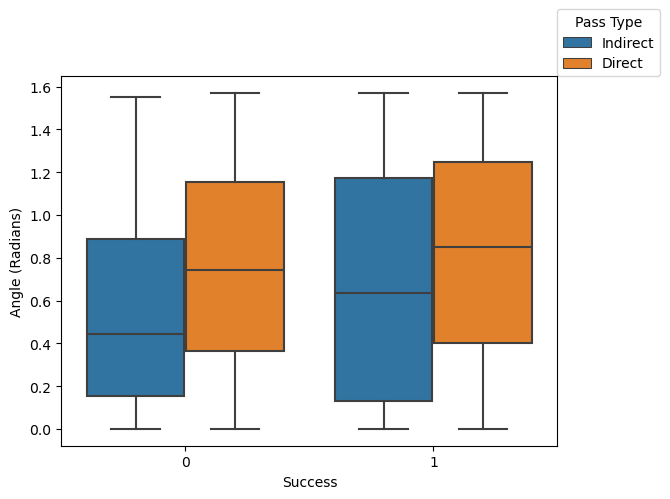

In [24]:
plot = sns.boxplot(x = angle_df['success'], 
            y = angle_df['angle'], 
            hue = angle_df['type'])
sns.move_legend(plot, loc=(1, 1), title='Pass Type')
plt.xlabel("Success")
plt.ylabel("Angle (Radians)")

Shown by the graph, the angles are quite similar between the successful and not successful plays. However, we do see that the angles for direct plays follow an approximately normal curve with the median at approximately 0.8, or approximately 45 degrees. This is interesting because we would expect that passing the puck in a straight 90 degree manner would be easiest. 

In [25]:
play_counts = duckdb.sql("""
                            SELECT Player, 
                            COUNT(Event) AS "Total",
                            COUNT (CASE WHEN Event = 'Play' THEN 1 END) AS "Play",
                            COUNT (CASE WHEN Event = 'Incomplete Play' THEN 1 END) AS "IncPlay"
                            FROM data
                            WHERE Event = 'Play' OR Event = 'Incomplete Play'
                            GROUP BY Player
                           """).df()

play2_counts = duckdb.sql("""
                            SELECT "Player 2" AS Player2, 
                            COUNT(Event) AS "Total",
                            COUNT (CASE WHEN Event = 'Play' THEN 1 END) AS "Play",
                            COUNT (CASE WHEN Event = 'Incomplete Play' THEN 1 END) AS "IncPlay"
                            FROM data
                            WHERE Event = 'Play' OR Event = 'Incomplete Play'
                            GROUP BY "Player 2"
                           """).df()

joint_play_count = pd.concat([play_counts, play2_counts], axis = 0)

joint_play_count['Player'] = joint_play_count['Player'].fillna(joint_play_count['Player2'])
joint_play_count = joint_play_count.drop(columns=['Player2'])

joint_play_count = duckdb.sql("""
                              SELECT Player,
                              SUM(Total) AS Total,
                              SUM (Play) AS Play,
                              SUM(IncPlay) AS IncPlay
                              FROM joint_play_count
                              GROUP BY Player
                              """).df()


joint_play_count["Rate"] = joint_play_count["Play"] / joint_play_count["Total"]
#print (joint_play_count)

lowest = joint_play_count.nsmallest(5, "Rate", 'all')
print (lowest)

                Player  Total  Play  IncPlay      Rate
53       Casey O'Brien    7.0   3.0      4.0  0.428571
14  Natalie Buchbinder   19.0  10.0      9.0  0.526316
21     Hayley Scamurra   80.0  50.0     30.0  0.625000
20   Jamie Lee Rattray   60.0  38.0     22.0  0.633333
17         Emily Clark  127.0  81.0     46.0  0.637795


Text(0, 0.5, 'Angle (Radians)')

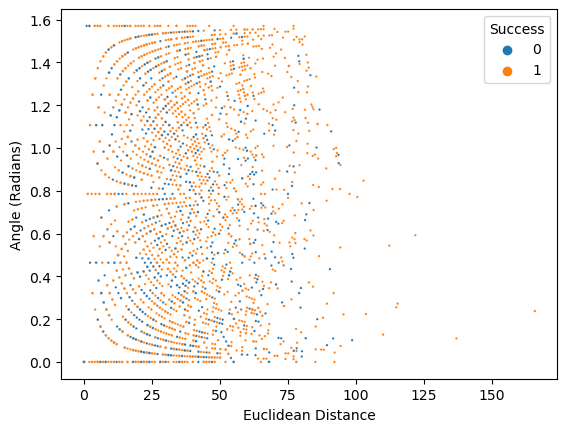

In [26]:
sns.scatterplot(x = df_pass["Distance"],
                y = df_pass["Angle"],
                hue = df_pass["Success"],
                s = 3)
plt.xlabel("Euclidean Distance")
plt.ylabel("Angle (Radians)")

In [27]:
sns.histplot(estimated_angle_coef)

NameError: name 'estimated_angle_coef' is not defined

In [ ]:
sns.scatterplot(model_mse)

In [ ]:
### ALL CODE BELOW IS NOT PART OF OFFICIAL ANALYSIS, too detailed
trial_num = 1000
estimated_dist_coef = np.zeros(trial_num)
estimated_angle_coef = np.zeros(trial_num)
model_mse = np.zeros(trial_num)
for i in range (trial_num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.3)
    logit_dist = LogisticRegression().fit(X_train, y_train)
    estimated_dist_coef[i] = logit_dist.coef_[0,0]
    estimated_angle_coef[i] = logit_dist.coef_[0,1]
    predicted = logit_dist.predict(X_test)
    model_mse[i] = np.square(np.subtract(y_test, predicted)).mean()
